# Tabulation of Fractional Cover data within shapefile polygons

**What does this notebook do?**

This notebook is a pilot collaboration between Geoscience Australia and Australian Bureau of Statistics. The purpose of the notebook is to use a shapefile polygon boundaries to load fractional cover dataset, complete zonal statistics and tabulate the results.

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`


**Background**

Data from the Landsat 5,7 and 8 satellite missions are accessible through Digital Earth Australia (DEA). The code snippets in this notebook will let you retrieve and plot the Fractional Cover (FC25) data stored in DEA.


**How to use this notebook**

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- UE - Unmixing Error
- Water Observations from Space (WOFs)
- WOfS Feature Layer (WOFL)

**Bugs still to fix**

- Memory errors for large (~2000 km^2) polygons
- tidy and document the `fc_polygon_tabulation()` module. Opportunity to create additional modules to declutter.

**Errors or bugs**

If you find an error or bug in this notebook, please contact erin.telfer@ga.gov.au.


## Import Libraries and define functions

In [1]:
import datacube
from datacube.utils import geometry
from datacube.storage import masking
dc = datacube.Datacube()

import numpy as np
import fiona
import rasterio.features
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from shapely.geometry import asShape

import sys
import os
sys.path.append('../other_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling

In [2]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    data = rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
    coords = [xr.DataArray(data=coord.values, name=dim, dims=[dim], attrs={'units': coord.units}) 
              for dim, coord in geobox.coords.items()]
    return xr.DataArray(data, coords=coords)

In [3]:
def filter_out_wofs(wofls, ds):
    wetwofl = masking.make_mask(wofls, wet=True)
    unwofld = ds.where(ds.time == wetwofl.time)
    unwofld = unwofld.where(wetwofl.water==False)
    return unwofld

In [4]:
def polygon_mask(geometry,geobox,unwofld, catchmentID):
    mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ds_masked = unwofld.where(mask_xr== False) #mask
    ds_masked.coords['catchment_ID'] = catchmentID #add catchment ID as xr coordinate
    ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]') #correct for ls solar day issues
    return ds_masked

In [12]:
def fc_daily(ds_masked,catchmentID):
    bs = ds_masked.BS.sum(dim=('x', 'y')) #bare soil
    pv = ds_masked.PV.sum(dim=('x', 'y')) #photosynthetic vegetation
    npv = ds_masked.NPV.sum(dim=('x', 'y')) #non-photosynthetic vegetation
    fc_sum = bs + pv + npv #sum all fc components for each time slice
    daily_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,}) #combine fc into xr dataset
     # caclulate area of each fc component
    daily_area_xr = daily_xr  * (25*25/10_000) 
    daily_area_xr = daily_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area',})
    #calculate percentage of fc component for each timeslice within polygon
    daily_xr = daily_xr / fc_sum * 100 #calculate percentage
    daily_xr = xr.merge([daily_xr,daily_area_xr]) #join percentage and area xr datasets together
    daily_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
    
    return fc_sum, daily_xr

In [6]:
def fc_annual(ds_masked, fc_sum,catchmentID, start):
    #sum each fc component spatially for each year
    bs_total = ds_masked.BS.sum(dim=('x', 'y','time'))
    pv_total = ds_masked.PV.sum(dim=('x', 'y','time'))
    npv_total = ds_masked.NPV.sum(dim=('x', 'y','time'))
    annual_xr = xr.Dataset({'bs':bs_total,'pv':pv_total,'npv':npv_total,}) #combine annual fc components into xr dataset
    # caclulate area of each annual fc component
    annual_area_xr = annual_xr * (25*25/10_000)
    annual_area_xr = annual_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area',})
    #calculate percentage of fc component for each year within polygon
    annual_xr = annual_xr /fc_sum.values.sum() * 100 
    annual_xr = xr.merge([annual_xr,annual_area_xr]) #join percentage and area xr datasets together
    annual_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
    annual_xr.coords['time'] = start #add time (year) as coordinate
    return annual_xr

In [18]:
def fc_polygon_tabulation(shape_file, year_start, year_end):
   #create empty dictionaries and lists 
    annual_dict = {}
    daily_dict = {}
    catchment_list = []
    
    #create a list of years between the start year and end year specified in the function
    year_list = list(range(year_start,year_end))
    
    #loop through each calendar year within the year list
    for start_year in year_list:
        end_year = start_year + 1
        print ('Processing '+str(start_year)+' to '+ str(end_year))
        #retrieve all polygons from shapefile
        shapes = get_shapes(shape_file)
        
        #loop through each polygon within shapefile
        for geometry, properties in shapes:
            catchmentID = 'ID_'+ str(properties['SA2_MAIN16']) #save catchment id from polygon properties as variable 
            print('Processing catchment '+str(catchmentID))
            geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
                                                                    [25.0, 25.0], 
                                                                    crs=geometry.crs, 
                                                                    align=None)#save spatial information from polygon
            #create query and load fc data
            start = str(start_year)+'-01-01'#create timestamp for each calendar year
            end  = str(start_year)+'-12-31'#create timestamp for each calendar year
            query = {'geopolygon': geometry,'time':(start, end)} #create dc query with polygon shapefile
            print('Catchment area is '+str(properties['AREASQKM16'])+' km2')
            ds = DEADataHandling.load_clearlandsat(dc, 
                                                   query, 
                                                   sensors=('ls5', 'ls7', 'ls8'),
                                                   product='fc',
                                                   masked_prop=0.80) #load fc data from datacube for specified year and polygon

            #if loaded fc dataset contains data then continue
            if ds.time.size != 0:
                #load a WOfS layer for each timeslice of fc data
                wofls = dc.load(product = 'wofs_albers', like=ds)
                #create a mask to remove wet pixels
                unwofld = filter_out_wofs(wofls, ds)
                del wofls
                #create a mask to remove data outside of polygon
                ds_masked = polygon_mask(geometry,geobox,unwofld, catchmentID)
                #sum each fc component spatially for each time slice
                fc_sum,daily_xr = fc_daily(ds_masked,catchmentID)
                
                if catchmentID not in daily_dict: #search whether ID is in dictionary 
                    daily_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
                daily_dict[catchmentID][str(start_year)] = daily_xr #save fc data into dictionary of dictionary

                #sum each fc component spatially for each year
                annual_xr = fc_annual(ds_masked, fc_sum, catchmentID,start)

                if catchmentID not in annual_dict:  #search whether ID is in dictionary
                    annual_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
                annual_dict[catchmentID][str(start_year)] = annual_xr #save fc data into dictionary of dictionary

                print('Catchment '+ str(catchmentID) +' complete')
                print('')
            #if loaded fc dataset does not contain then break current loop
            else:
                break

    #concatenate dictionaries together
    daily_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in daily_dict.items()} #concatenate dictionary of dates together
    daily_fc_clean = xr.concat(daily_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together
    annual_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in annual_dict.items()} #concatenate dictionary of dates together
    annual_fc_clean = xr.concat(annual_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together

    print('Complete')
    return daily_fc_clean, annual_fc_clean #output two xr datasets; daily fc and annual fc

In [19]:
def get_shapes(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = datacube.utils.geometry.CRS(shapes.crs_wkt)
        for shape in shapes:
            geom = datacube.utils.geometry.Geometry(shape['geometry'], crs=crs)
            yield geom, shape['properties']

## Use shapefile to return relevant data

In [20]:
# Set this to the location of water body shapefile
# shape_file = os.path.expanduser('SA_2016_edited_3577.shp')
shape_file = os.path.expanduser('SA_2016_twopolygons_3577.shp')


#open shapefile and save spatial variables
with fiona.open(shape_file) as shapes:
    crs = geometry.CRS(shapes.crs_wkt)
    first_geometry = next(iter(shapes))['geometry']
    geom = geometry.Geometry(first_geometry, crs=crs)

In [21]:
#ignore warning messages
import warnings
warnings.simplefilter("ignore")

In [22]:
#use function to tabulate fc components within each polygon in shapefile, for time between years specified. Returns daily and annual averages
daily_fc_clean, annual_fc_clean = fc_polygon_tabulation(shape_file, 2000, 2002)

Processing 2000 to 2001
Processing catchment ID_201021011
Catchment area is 920.7579 km2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 7 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_201021011 complete

Processing catchment ID_216031418
Catchment area is 1055.5778 km2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 18 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_216031418 complete

Processing 2001 to 2002
Processing catchment ID_201021011
Catchment area is 920.7579 km2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 11 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_201021011 complete

Processing catchment ID_216031418
Catchment area is 1055.5778 km2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 19 

In [23]:
#print daily fc values
daily_fc_clean

<xarray.Dataset>
Dimensions:       (catchment_ID: 2, time: 43)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-31 2000-02-16 ... 2001-11-24
  * catchment_ID  (catchment_ID) <U12 'ID_201021011' 'ID_216031418'
Data variables:
    bs            (catchment_ID, time) float64 nan nan nan ... 9.891 7.414 15.97
    pv            (catchment_ID, time) float64 nan nan nan ... 67.52 67.14 39.57
    npv           (catchment_ID, time) float64 nan nan nan ... 22.59 25.45 44.47
    bs_area       (catchment_ID, time) float64 nan nan ... 6.404e+05 1.357e+06
    pv_area       (catchment_ID, time) float64 nan nan nan ... 5.8e+06 3.362e+06
    npv_area      (catchment_ID, time) float64 nan nan ... 2.198e+06 3.779e+06

In [24]:
#print annual fc values
annual_fc_clean

<xarray.Dataset>
Dimensions:       (catchment_ID: 2, time: 2)
Coordinates:
  * time          (time) <U10 '2000-01-01' '2001-01-01'
  * catchment_ID  (catchment_ID) <U12 'ID_201021011' 'ID_216031418'
Data variables:
    bs            (catchment_ID, time) float64 7.043 10.66 12.37 12.66
    pv            (catchment_ID, time) float64 64.85 49.11 51.05 45.18
    npv           (catchment_ID, time) float64 28.1 40.23 36.58 42.16
    bs_area       (catchment_ID, time) float64 2.399e+06 5.719e+06 ... 2.367e+07
    pv_area       (catchment_ID, time) float64 2.209e+07 2.635e+07 ... 8.449e+07
    npv_area      (catchment_ID, time) float64 9.574e+06 2.158e+07 ... 7.884e+07

## save output as .csv

In [25]:
daily_fc_df = daily_fc_clean.dropna(dim='time').to_dataframe().to_csv('fc_daily_twopolygons.csv')
annual_fc_df = annual_fc_clean.dropna(dim='time').to_dataframe().to_csv('fc_annual_twopolygons.csv')

## plot fc percentages

In [26]:
catch_ID = 1 #set catchment ID

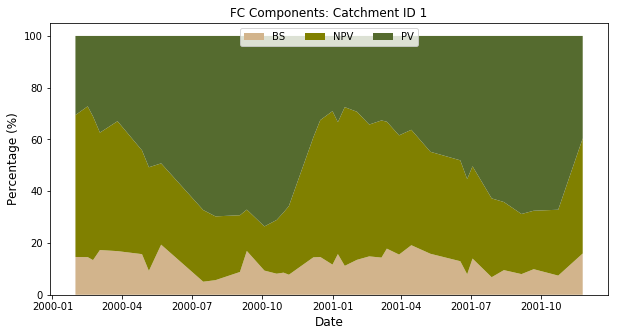

In [27]:
#plot fc percentages for all (daily time slices) results. Results are for the catchment ID specified, above.
fig,ax = plt.subplots(figsize=(10,5))
ax.stackplot(np.asanyarray(daily_fc_clean.isel(catchment_ID = catch_ID).dropna(dim='time').time), 
             np.asanyarray(daily_fc_clean.isel(catchment_ID = catch_ID).dropna(dim='time').bs), 
             np.asanyarray(daily_fc_clean.isel(catchment_ID = catch_ID).dropna(dim='time').npv), 
             np.asanyarray(daily_fc_clean.isel(catchment_ID = catch_ID).dropna(dim='time').pv),
             colors = ['tan','olive','darkolivegreen',], 
             labels=['BS','NPV','PV',])
plt.legend(loc='upper center', ncol = 3)
plt.title('FC Components: Catchment ID '+str(catch_ID), size=12)
plt.ylabel('Percentage (%)', size=12) #Set Y label
plt.xlabel('Date', size=12) #Set X label
plt.savefig('fc_daily_ID'+str(catch_ID)+'.png')

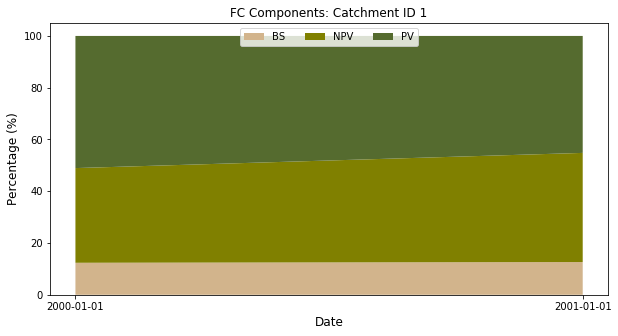

In [28]:
#plot fc percentages for annual time slices. Results are for the catchment ID specified, above.

fig,ax = plt.subplots(figsize=(10,5))
ax.stackplot(np.asanyarray(annual_fc_clean.isel(catchment_ID = catch_ID).time), 
             np.asanyarray(annual_fc_clean.isel(catchment_ID = catch_ID).bs), 
             np.asanyarray(annual_fc_clean.isel(catchment_ID = catch_ID).npv), 
             np.asanyarray(annual_fc_clean.isel(catchment_ID = catch_ID).pv),
             colors = ['tan','olive','darkolivegreen',], 
             labels=['BS','NPV','PV',])
plt.legend(loc='upper center', ncol = 3)
plt.ylabel('Percentage (%)', size=12) #Set Y label
plt.xlabel('Date', size=12) #Set X label
plt.title('FC Components: Catchment ID '+str(catch_ID), size=12)
# plt.xticks(rotation=45)
plt.savefig('fc_annual_ID'+str(catch_ID)+'.png')

In [ ]:
# def fc_polygon_tabulation(shape_file, year_start, year_end):
#    #create empty dictionaries and lists 
#     annual_dict = {}
#     daily_dict = {}
#     catchment_list = []
#     #create a list of years between the start year and end year specified in the function
#     year_list = list(range(year_start,year_end))
#     #loop through each calendar year within the year list
#     for start_year in year_list:
#         end_year = start_year + 1
#         print ('Processing '+str(start_year)+' to '+ str(end_year))
#         #retrieve all polygons from shapefile
#         shapes = get_shapes(shape_file)
#         #loop through each polygon within shapefile
#         for geometry, properties in shapes:
#             #save catchment id from polygon properties as variable 
#             catchmentID = 'ID_'+ str(properties['SA2_MAIN16'])
#             print('Processing catchment '+str(catchmentID))
#             #save spatial information from polygon
#             geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                                     [25.0, 25.0], 
#                                                                     crs=geometry.crs, 
#                                                                     align=None)
#             #create timestamp for each calendar year
#             start = str(start_year)+'-01-01'
#             end  = str(start_year)+'-12-31'
#             #create dc query with polygon shapefile
#             query = {'geopolygon': geometry,'time':(start, end)}
#             #load fc data from datacube for specified year and polygon
#             print('Catchment area is '+str(properties['AREASQKM16'])+' km2')
#             ds = DEADataHandling.load_clearlandsat(dc, 
#                                                    query, 
#                                                    sensors=('ls5', 'ls7', 'ls8'),
#                                                    product='fc',
#                                                    masked_prop=0.80)
#             #if loaded fc dataset contains data then continue
#             if ds.time.size != 0:
#                 #load a WOfS layer for each timeslice of fc data
#                 wofls = dc.load(product = 'wofs_albers', like=ds)

#                 #create a mask to remove wet pixels
#                 wetwofl = masking.make_mask(wofls, wet=True)
#                 del wofls
#                 unwofld = ds.where(ds.time == wetwofl.time)
#                 unwofld = unwofld.where(wetwofl.water==False)

#                 #create a mask to remove data outside of polygon
#                 mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#                 mask_xr = xr.DataArray(mask, dims = ('y','x'))
#                 ds_masked = unwofld.where(mask_xr== False) #mask
#                 ds_masked.coords['catchment_ID'] = catchmentID #add catchment ID as xr coordinate
#                 ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]') #correct for ls solar day issues

#                 #sum each fc component spatially for each time slice
#                 bs = ds_masked.BS.sum(dim=('x', 'y')) #bare soil
#                 pv = ds_masked.PV.sum(dim=('x', 'y')) #photosynthetic vegetation
#                 npv = ds_masked.NPV.sum(dim=('x', 'y')) #non-photosynthetic vegetation

#                 fc_sum = bs + pv + npv #sum all fc components for each time slice
#                 daily_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,}) #combine fc into xr dataset

#                 # caclulate area of each fc component
#                 annual_area_xr = daily_xr  * (25*25/10_000) 
#                 annual_area_xr = annual_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area',})
#                 #calculate percentage of fc component for each timeslice within polygon
#                 daily_xr = daily_xr / fc_sum * 100 #calculate percentage
#                 daily_xr = xr.merge([daily_xr,annual_area_xr]) #join percentage and area xr datasets together
#                 daily_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
#                 if catchmentID not in daily_dict: #search whether ID is in dictionary 
#                     daily_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
#                 daily_dict[catchmentID][str(start_year)] = daily_xr #save fc data into dictionary of dictionary

#                 #sum each fc component spatially for each year
#                 bs_total = ds_masked.BS.sum(dim=('x', 'y','time'))
#                 pv_total = ds_masked.PV.sum(dim=('x', 'y','time'))
#                 npv_total = ds_masked.NPV.sum(dim=('x', 'y','time'))
#                 annual_xr = xr.Dataset({'bs':bs_total,'pv':pv_total,'npv':npv_total,}) #combine annual fc components into xr dataset
#                 # caclulate area of each annual fc component
#                 annual_area_xr = annual_xr * (25*25/10_000)
#                 annual_area_xr = annual_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area',})
#                 #calculate percentage of fc component for each year within polygon
#                 annual_xr = annual_xr /fc_sum.values.sum() * 100 
#                 annual_xr = xr.merge([annual_xr,annual_area_xr]) #join percentage and area xr datasets together
#                 annual_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
#                 annual_xr.coords['time'] = start #add time (year) as coordinate

#                 if catchmentID not in annual_dict:  #search whether ID is in dictionary
#                     annual_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
#                 annual_dict[catchmentID][str(start_year)] = annual_xr #save fc data into dictionary of dictionary

#                 print('Catchment '+ str(catchmentID) +' complete')
#                 print('')
#             #if loaded fc dataset does not contain then break current loop
#             else:
#                 break

#     #concatenate dictionaries together
#     daily_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in daily_dict.items()} #concatenate dictionary of dates together
#     daily_fc_clean = xr.concat(daily_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together
#     annual_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in annual_dict.items()} #concatenate dictionary of dates together
#     annual_fc_clean = xr.concat(annual_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together

#     print('Complete')
#     return daily_fc_clean, annual_fc_clean #output two xr datasets; daily fc and annual fc